In [1]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
import qutip as qt
from IPython.display import HTML
import scipy as sp

%matplotlib ipympl
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=200, formatter={'float': '{:.3f}'.format})

# Study of the properties of the qubit vs inductance asymmetry (Δ) and external flux (φ_ext)

In [2]:
# Fundamental constants
h    = 6.62607015e-34
GHz  = 1e9
e0   = 1.602176634e-19
Φ_0  = h/(2*e0)

## KIT's qubit

This notebook studies the qubit proposed by KIT. It's lumped element model is:
<img src='Other/Single qubit 4 nodes CC coupled to ground.jpg' width='500'>


In [3]:
# Circuit parameters
Csh = 15
C   = 15
Cg  = 10
CJ  = 3
Lq  = 25
Lr  = 10
Δ   = 0.1
EJ  = 10.0
l = Lq*(Lq+4*Lr) - 4*Δ**2

E_J = EJ * 1e9
L_r = l/Lq * 1e-9
E_L_r = (Φ_0/(2*np.pi))**2/L_r / h

In [4]:
Cf = C/2 + Csh + CJ
Lf = l/(Lq+4*Lr)
C_f = Cf * 1e-15
L_f = Lf * 1e-9
Z_f = np.sqrt(L_f/C_f)

L_r = l/Lq * 1e-9
C_r = C/2 * 1e-15
Z_r = np.sqrt(L_r/C_r)

In [5]:
φ_ext_avoided_crossing_1q_1r = 0.372
φ_ext_avoided_crossing_2q_1r = 0.464

In [6]:
n_max_resonator = 30
n_max_fluxonium = 30

trunc_nums_resonator = [n_max_resonator]
trunc_nums_fluxonium = [n_max_fluxonium]

trunc_nums = [1, n_max_resonator, n_max_fluxonium]
trunc_nums_Δ_0 = [ n_max_resonator, n_max_fluxonium]

# Single circuit study

In [7]:
Δ = 1 # 1e-10
# Δ_dependance = 'not in energies'
# Δ_dependance = 'not in coupling'
Δ_dependance = 'all'

if Δ_dependance == 'all':
    # Original Lq and Lr, everything depends on Δ
    Lq_prime  = Lq
    Lr_prime  = Lr
elif Δ_dependance == 'not in energies':
    # Lr and Lq such that ωr and ωf !=f(Δ) and hence there is no renormalization
    Lq_prime  = (Lq*(Lq + 4*Lr) + np.sqrt(Lq*(Lq + 4*Lr)*(Lq**2 + 4*Lq*Lr + 16*Δ**2)))/(2*(Lq + 4*Lr))
    Lr_prime  = Lr*(Lq*(Lq + 4*Lr) + np.sqrt(Lq*(Lq + 4*Lr)*(Lq**2 + 4*Lq*Lr + 16*Δ**2)))/(2*Lq*(Lq + 4*Lr))
elif Δ_dependance == 'not in coupling':
    # Lr and Lq such that L^2 !=f(Δ) and hence the coupling inductance does not depend on delta
    Lq_prime = np.sqrt(Δ)*Lq
    Lr_prime = np.sqrt(Δ)*Lr + Δ **2 /(Lq*np.sqrt(Δ))

qubit     = sq_ext.KIT_qubit     (Δ=Δ, Lq =Lq_prime, Lr =Lr_prime)
fluxonium = sq_ext.KIT_fluxonium (Δ=Δ, Lq =Lq_prime, Lr =Lr_prime)
resonator = sq_ext.KIT_resonator (Δ=Δ, Lq =Lq_prime, Lr =Lr_prime)

try:
    qubit.set_trunc_nums(trunc_nums)
except:
    try:
        qubit.set_trunc_nums(trunc_nums_Δ_0)
    except:
        qubit.set_trunc_nums([trunc_nums_resonator[0]*trunc_nums_fluxonium[0]])

resonator.set_trunc_nums(trunc_nums_resonator)
fluxonium.set_trunc_nums(trunc_nums_fluxonium)

_ = qubit    .diag(4)
_ = resonator.diag(4)
_ = fluxonium.diag(4)

H_frc   = sq_ext.hamiltonian_frc(fluxonium, resonator, Δ)
E_frc, _ = sq_ext.diag(H_frc)

In [8]:
qubit.efreqs[1]-qubit.efreqs[0]

1.942613978298949

In [9]:
E_frc[1]-E_frc[0]

1.9426139774605482

# Circuit vs Δ study

In [10]:
geom_len = 20
lin_len = 5
# Δ_dependance = 'not in energies'
# Δ_dependance = 'not in coupling'
Δ_dependance = 'all'

# Δ_values = np.concatenate( (np.array([1e-10]), np.geomspace(1e-3,1e-1, geom_len * 2//3), np.geomspace(1e-1,1, geom_len//3), np.linspace(1,10,lin_len) ))
Δ_values = np.concatenate( (np.array([1e-10]), np.geomspace(1e-6, 1e-1, geom_len), np.linspace(1e-1,1,lin_len) ))
# Δ_values = np.array([1e-6, 1])

qubit_vs_Δ =     [ ]
resonator_vs_Δ = [ ]
fluxonium_vs_Δ = [ ]
H_frc_vs_Δ = [ ]
L_r_vs_Δ = [ ]
L_f_vs_Δ = [ ]
L_c_vs_Δ = [ ]

for Δ in Δ_values:

    if Δ_dependance == 'all':
        # Original Lq and Lr, everything depends on Δ
        Lq_prime  = Lq
        Lr_prime  = Lr
    elif Δ_dependance == 'not in energies':
        # Lr and Lq such that ωr and ωf !=f(Δ) and hence there is no renormalization
        Lq_prime  = (Lq*(Lq + 4*Lr) + np.sqrt(Lq*(Lq + 4*Lr)*(Lq**2 + 4*Lq*Lr + 16*Δ**2)))/(2*(Lq + 4*Lr))
        Lr_prime  = Lr*(Lq*(Lq + 4*Lr) + np.sqrt(Lq*(Lq + 4*Lr)*(Lq**2 + 4*Lq*Lr + 16*Δ**2)))/(2*Lq*(Lq + 4*Lr))
    elif Δ_dependance == 'not in coupling':
        # Lr and Lq such that L^2 !=f(Δ) and hence the coupling inductance does not depend on delta
        Lq_prime = np.sqrt(Δ)*Lq
        Lr_prime = np.sqrt(Δ)*Lr + Δ **2 /(Lq*np.sqrt(Δ))
    
    l = Lq_prime*(Lq_prime+4*Lr_prime) - 4*Δ**2    
    L_r_vs_Δ.append( l/Lq_prime                 * 1e-9 )
    L_f_vs_Δ.append( l/(Lq_prime+4*Lr_prime)    * 1e-9 )
    L_c_vs_Δ.append( l/Δ                        * 1e-9 )

    qubit     = sq_ext.KIT_qubit    (Δ=Δ, Lq =Lq_prime, Lr =Lr_prime)
    fluxonium = sq_ext.KIT_fluxonium(Δ=Δ, Lq =Lq_prime, Lr =Lr_prime)
    resonator = sq_ext.KIT_resonator(Δ=Δ, Lq =Lq_prime, Lr =Lr_prime)

    resonator.set_trunc_nums(trunc_nums_resonator)
    fluxonium.set_trunc_nums(trunc_nums_fluxonium)
    try:
        qubit.set_trunc_nums(trunc_nums)
    except:
        try:
            qubit.set_trunc_nums(trunc_nums_Δ_0)
        except:
            qubit.set_trunc_nums([trunc_nums_resonator[0]*trunc_nums_fluxonium[0]])

    qubit_vs_Δ    .append(qubit)
    fluxonium_vs_Δ.append(fluxonium)
    resonator_vs_Δ.append(resonator)
    H_frc_vs_Δ    .append(sq_ext.hamiltonian_frc(fluxonium, resonator, Δ, Lq =Lq_prime, Lr =Lr_prime))

In [11]:
φ_ext = 0.5
n_eig = 4
eig_index = 0

ψ_q_vs_Δ     = []
ψ_frc_vs_Δ   = [] 
ψ_fr_vs_Δ    = []

E_q_vs_Δ   = []
E_frc_vs_Δ = [] 
E_fr_vs_Δ  = []
E_f_vs_Δ  = []
E_r_vs_Δ  = []

for resonator_Δ, fluxonium_Δ, qubit_Δ, H_frc, Δ in zip(resonator_vs_Δ, fluxonium_vs_Δ, qubit_vs_Δ, H_frc_vs_Δ, Δ_values):
    try:
        fluxonium_Δ.loops[0].set_flux(φ_ext)
        qubit_Δ.loops[0].set_flux(φ_ext)
    except:
        pass

    _, _ = resonator_Δ.diag(n_eig)
    _, _ = fluxonium_Δ.diag(n_eig)
    _, _ = qubit_Δ.diag(n_eig)

    E_f_vs_Δ.append( fluxonium_Δ.efreqs)
    E_r_vs_Δ.append( resonator_Δ.efreqs )
    
    N_f, N_r      = sq_ext.get_energy_indices(qubit_Δ, fluxonium_Δ, resonator_Δ)
    E_frc, ψ_frc = sq_ext.diag(H_frc)
    
    E_q_vs_Δ     .append( qubit_Δ.efreqs-qubit_Δ.efreqs[0] )
    E_fr_vs_Δ   .append( fluxonium_Δ.efreqs[N_f] + resonator_Δ.efreqs[N_r] )
    E_frc_vs_Δ    .append( E_frc )

    ψ_q_vs_Δ     .append( qubit_Δ._evecs[eig_index].__array__().ravel())
    ψ_fr_vs_Δ    .append( qt.tensor(resonator_Δ._evecs[N_r[eig_index]], fluxonium_Δ._evecs[N_f[eig_index]]).__array__().ravel())
    ψ_frc_vs_Δ   .append( ψ_frc[eig_index])

ψ_error_q_fr_vs_Δ   = []
ψ_error_q_frc_vs_Δ  = []
ψ_error_frc_fr_vs_Δ = []

E_error_q_fr_vs_Δ    = []
E_error_q_frc_vs_Δ   = []
E_error_fr_frc_vs_Δ  = []

for ψ_q, ψ_fr, ψ_frc, E_q, E_frc, E_fr in zip(ψ_q_vs_Δ, ψ_fr_vs_Δ, ψ_frc_vs_Δ, E_q_vs_Δ, E_frc_vs_Δ, E_fr_vs_Δ):
    ψ_error_q_fr_vs_Δ  .append( 1 - np.abs(ψ_q.conj().T   @ ψ_fr )  )
    ψ_error_q_frc_vs_Δ .append( 1 - np.abs(ψ_q.conj().T   @ ψ_frc))
    ψ_error_frc_fr_vs_Δ.append( 1 - np.abs(ψ_frc.conj().T @ ψ_fr)   )

    E_error_q_frc_vs_Δ .append( np.abs(E_q   - E_frc))#/ E_q )
    E_error_q_fr_vs_Δ  .append( np.abs(E_q   - E_fr) )#/ E_q )
    E_error_fr_frc_vs_Δ.append( np.abs(E_frc - E_fr) )#/ E_q )

E_error_q_frc_vs_Δ  = np.array(E_error_q_frc_vs_Δ ).T
E_error_q_fr_vs_Δ   = np.array(E_error_q_fr_vs_Δ  ).T
E_error_fr_frc_vs_Δ = np.array(E_error_fr_frc_vs_Δ).T

# Consistency checks

### Energies

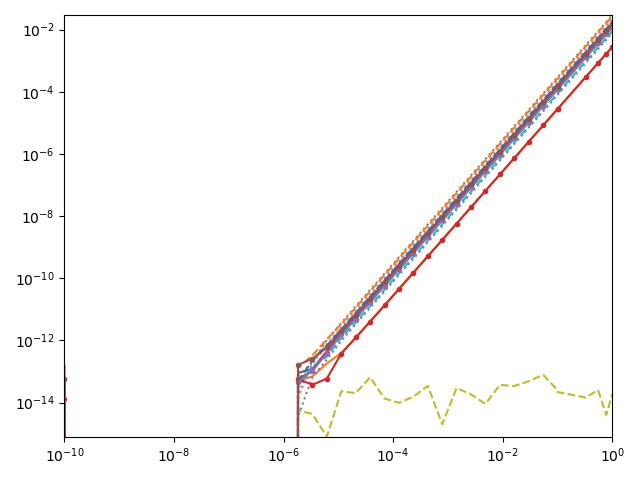

In [12]:
zero_index = 1
fig, ax = plt.subplots()
ax.plot(Δ_values, np.abs(E_q_vs_Δ-E_q_vs_Δ    [zero_index]) )
ax.plot(Δ_values, np.abs(E_f_vs_Δ-E_f_vs_Δ    [zero_index]), ':' )
ax.plot(Δ_values, np.abs(E_r_vs_Δ-E_r_vs_Δ    [zero_index]), '--')
ax.plot(Δ_values, np.abs(E_frc_vs_Δ-E_frc_vs_Δ[zero_index]),'.-' )
# ax.plot(Δ_values, np.abs(E_fr_vs_Δ-E_fr_vs_Δ  [zero_index]  ), '--')
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([1e-3,1e0])
ax.margins(0)
fig.tight_layout()
fig.show()

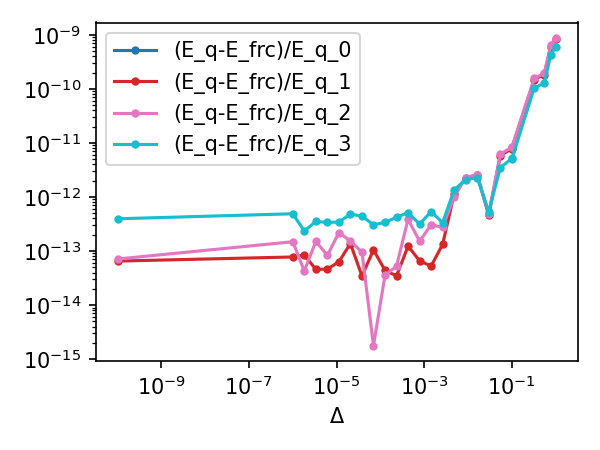

In [13]:
colors = figs.generate_colors_from_colormap(n_eig, 'tab10')

fig, ax = plt.subplots(dpi=150, figsize=[4,3])

for i, (E_error_q_frc, E_error_q_fr, E_error_fr_frc) in enumerate( zip(E_error_q_frc_vs_Δ, E_error_q_fr_vs_Δ, E_error_fr_frc_vs_Δ)):
    if i == 0:
        label_2 = '(E_q-E_fr)/E_q' + f'_{i}'
        label_3 = '(E_fr-E_frc)/E_q' + f'_{i}'
    else:
        label_2 = label_3 = None

    label_1 = '(E_q-E_frc)/E_q'  + f'_{i}'
    ax.plot(Δ_values, E_error_q_frc, '.-', color = colors[i],  label  = label_1 )
    # ax.plot(Δ_values, E_error_q_fr, ':' , color = colors[i],   label  = label_2 )
    # ax.plot(Δ_values, E_error_fr_frc, '--', color = colors[i], label  = label_3 )

ax.legend()

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\Delta$')
# ax.set_xlim([1e-5,1e0])
# ax.set_ylim([1e-12,1e-9])
fig.tight_layout()
fig.show()

### Wavefunctions

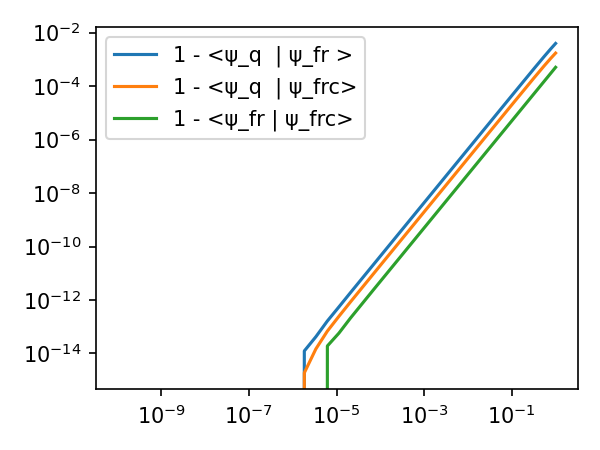

In [14]:
fig, ax = plt.subplots(dpi=150, figsize=[4,3])
ax.plot(Δ_values, np.array(ψ_error_q_fr_vs_Δ) ,label   = '1 - <ψ_q  | ψ_fr >')
ax.plot(Δ_values, np.array(ψ_error_q_frc_vs_Δ) ,label  = '1 - <ψ_q  | ψ_frc>')
ax.plot(Δ_values, np.array(ψ_error_frc_fr_vs_Δ),label = '1 - <ψ_fr | ψ_frc>')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
fig.tight_layout()
fig.show()

### Hamiltonian

In [16]:
H = qubit_vs_Δ[0].hamiltonian().__array__()
H_frc = H_frc_vs_Δ[0]

In [17]:
np.abs(np.imag(H)).sum(), np.abs(np.imag(H_frc)).sum()

(0.0, 0.0)

In [260]:
H = np.real(H)
H_fr = np.real(H_fr)

#### Diagonal

In [263]:
(H_fr_d.sum()-H_d.sum())

-218736044.125

In [255]:
(H_fr_d.sum()-H_d.sum())

-218736044.125

In [270]:
H_d.sum()

636028144436010.1

In [268]:
H_fr_d.sum()

636027925699966.0

In [ ]:
636027925699966.0

In [243]:
H_d = np.diag(H)
H_fr_d = np.diag(H_fr)
diff_d = (H_d - H_fr_d) / H_d
np.sum( ~np.isclose(H_d,H_fr_d)), H.size

(0, 390625)

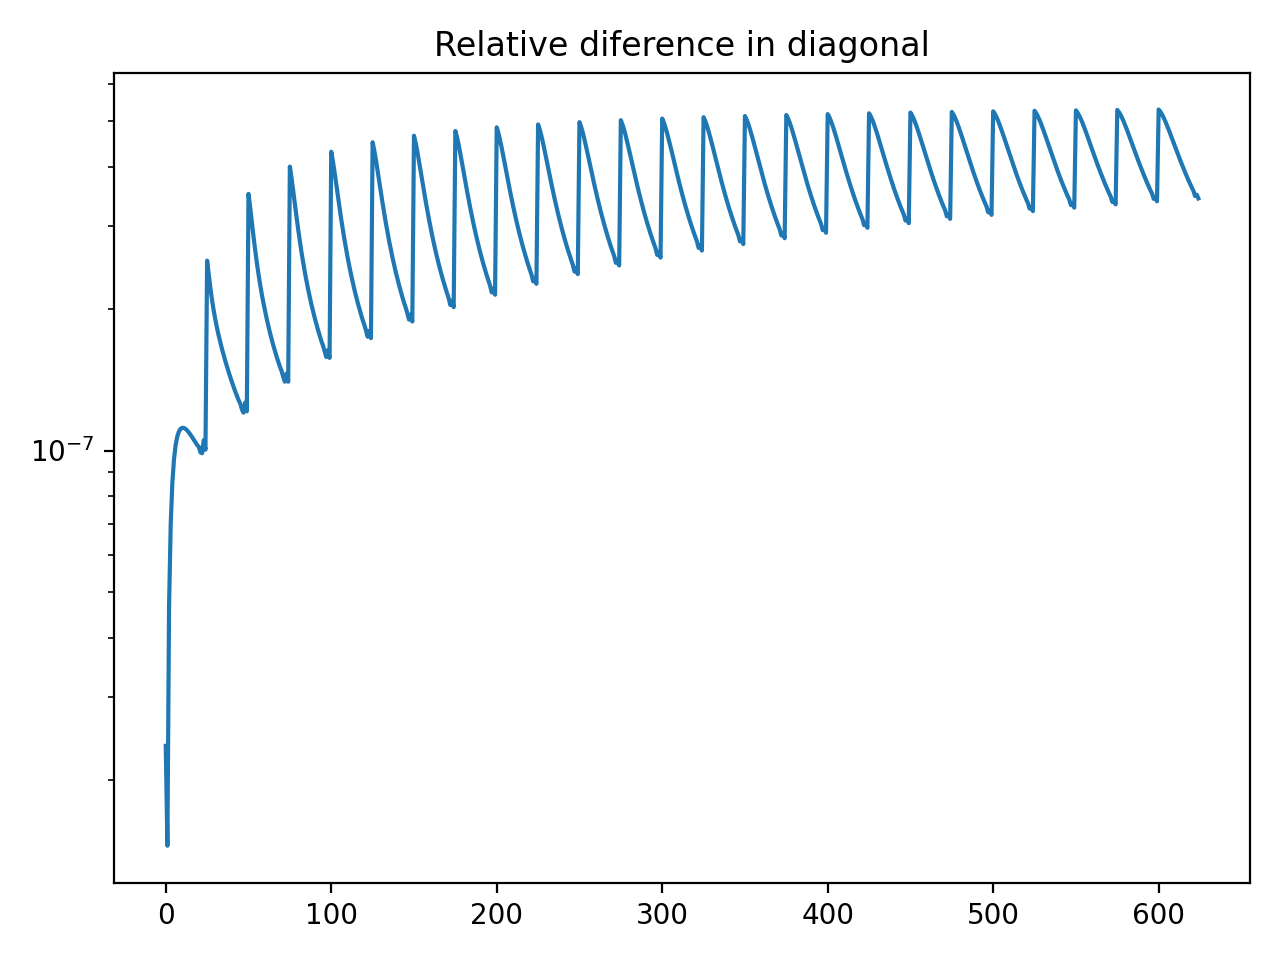

In [236]:
fig, ax = plt.subplots(dpi=200)
c1 = ax.plot(np.abs(np.real(diff_d)))
ax.set_title('Relative diference in diagonal')
ax.set_yscale('log')
fig.tight_layout()
fig.show()

In [92]:
H_od = H - np.diag(np.diag(H))
H_fr_od = H_fr - np.diag(np.diag(H_fr))
diff_od = (H_od - H_fr_od) / (H_od+1)
np.sum( ~np.isclose(H_od,H_fr_od)), H_od.size - H_od.shape[0]

(66450, 390000)

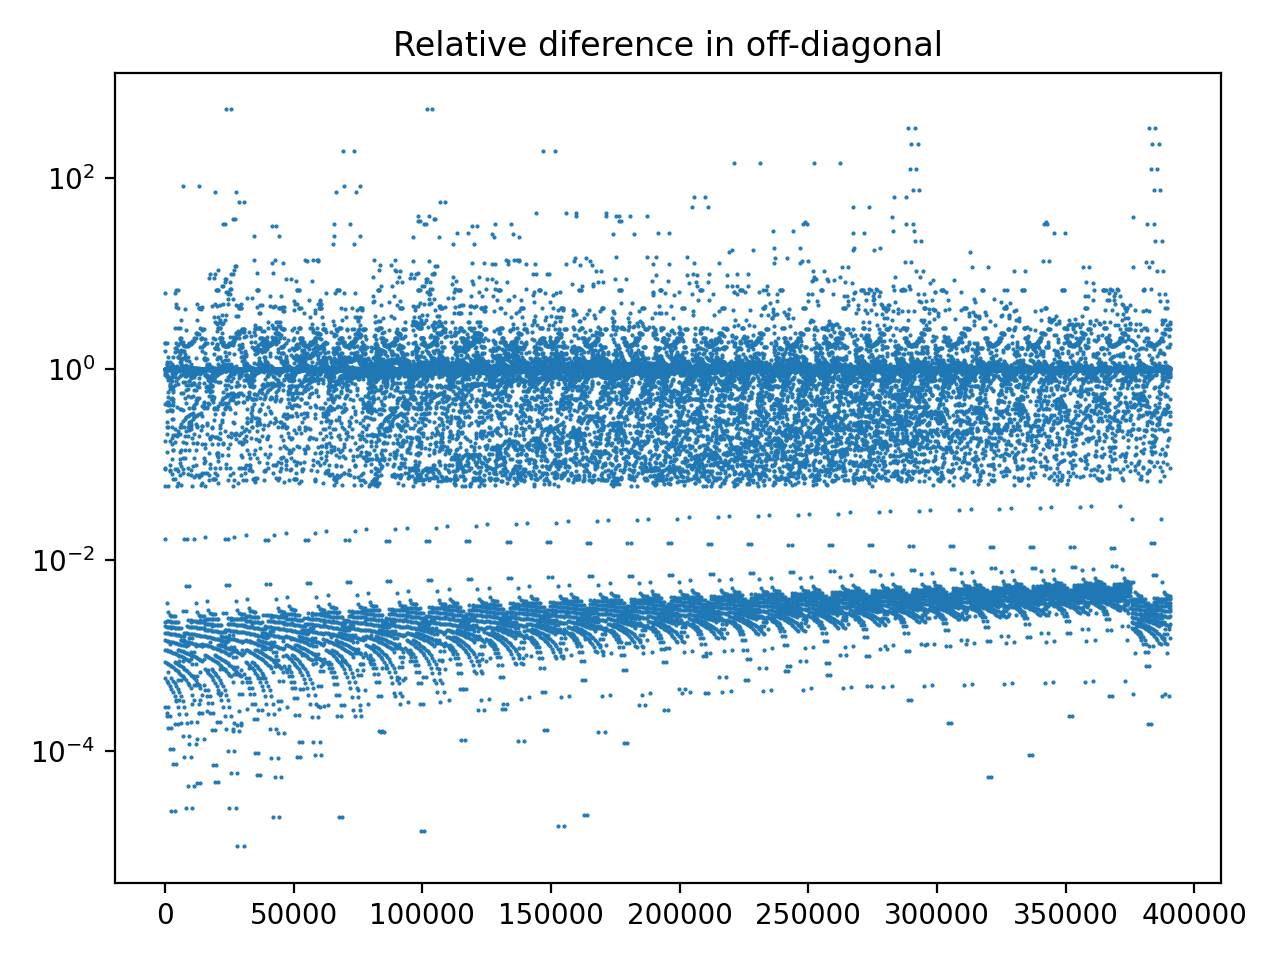

In [94]:
fig, ax = plt.subplots(dpi=200)
c1 = ax.plot(np.abs(diff_od).ravel(), '.', markersize=1)
ax.set_title('Relative diference in off-diagonal')
ax.set_yscale('log')
fig.tight_layout()
fig.show()

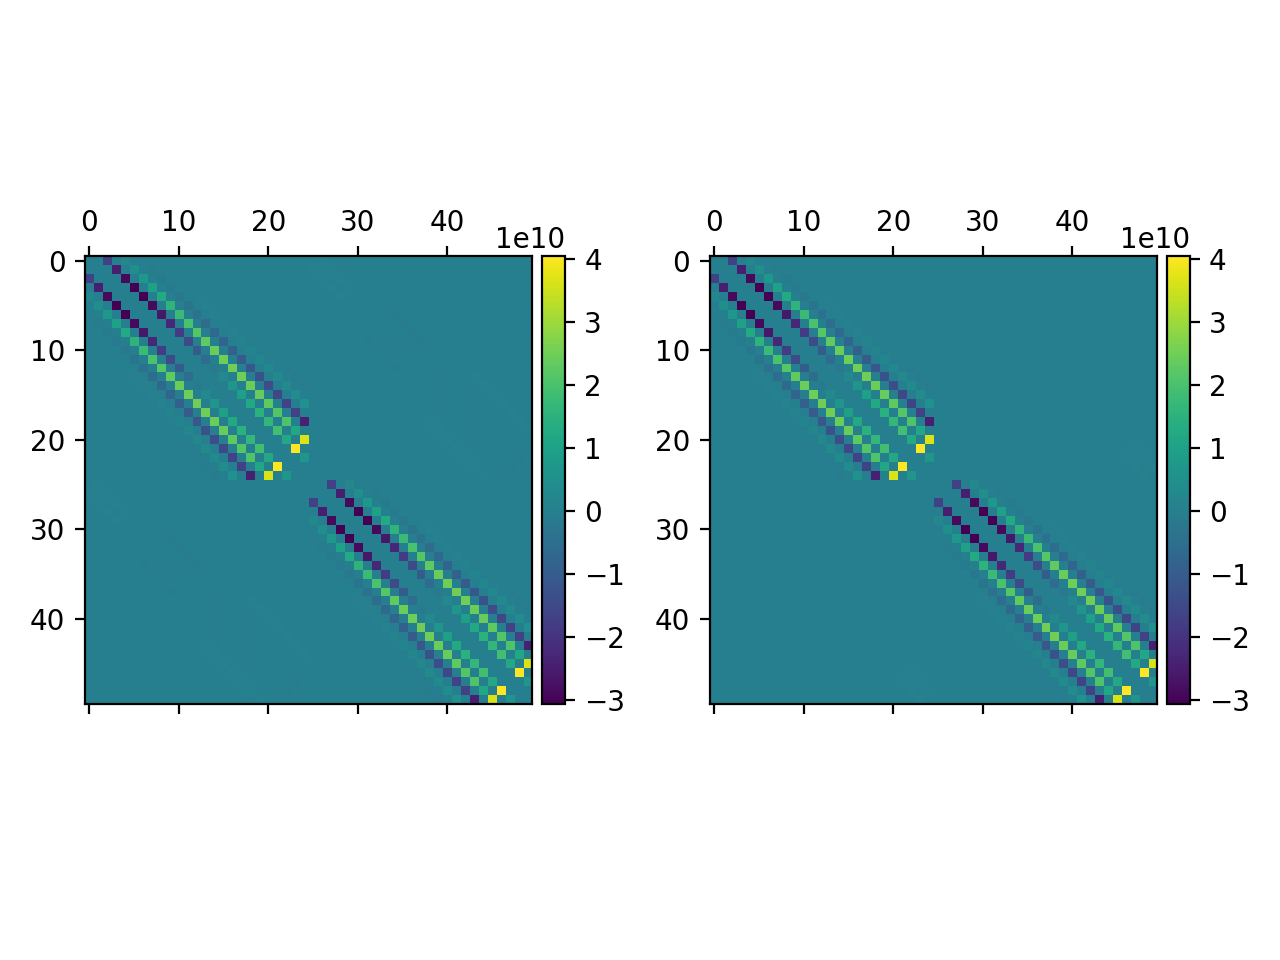

In [131]:
fig, ax = plt.subplots(ncols=2, dpi=200)
c1 = ax[0].matshow(np.real(H_od[:50,:50]))
c2 = ax[1].matshow(np.real(H_fr_od[:50,:50]))
figs.colorbar(c1)
figs.colorbar(c2)
fig.tight_layout()
fig.show()

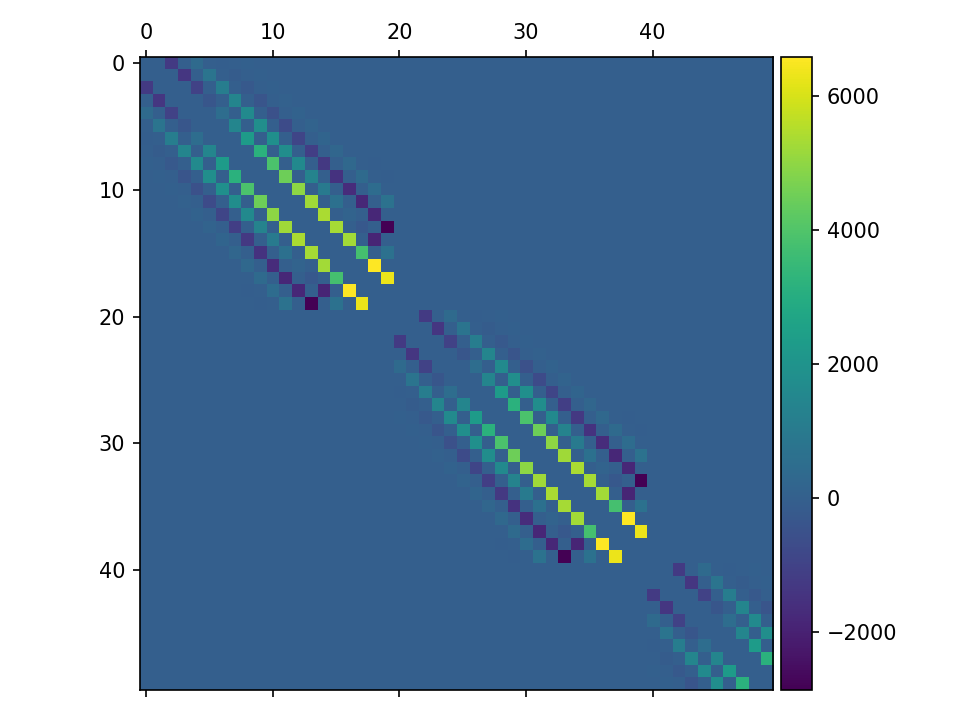

In [216]:
fig, ax = plt.subplots( dpi=150)
c1 = ax.matshow(np.real(H_od[:50,:50]-H_fr_od[:50,:50]))
figs.colorbar(c1)
fig.tight_layout()
fig.show()

### Coupling term

In [136]:
H = qubit_vs_Δ[-1].hamiltonian()
H_0 = qubit_vs_Δ[0].hamiltonian()

In [137]:
ΦfΦr_circuit = H - H_0
ΦfΦr_fr = sq_ext.internal_coupling_fluxonium_resonator(fluxonium_vs_Δ[-1], resonator_vs_Δ[-1], Δ_values[-1])

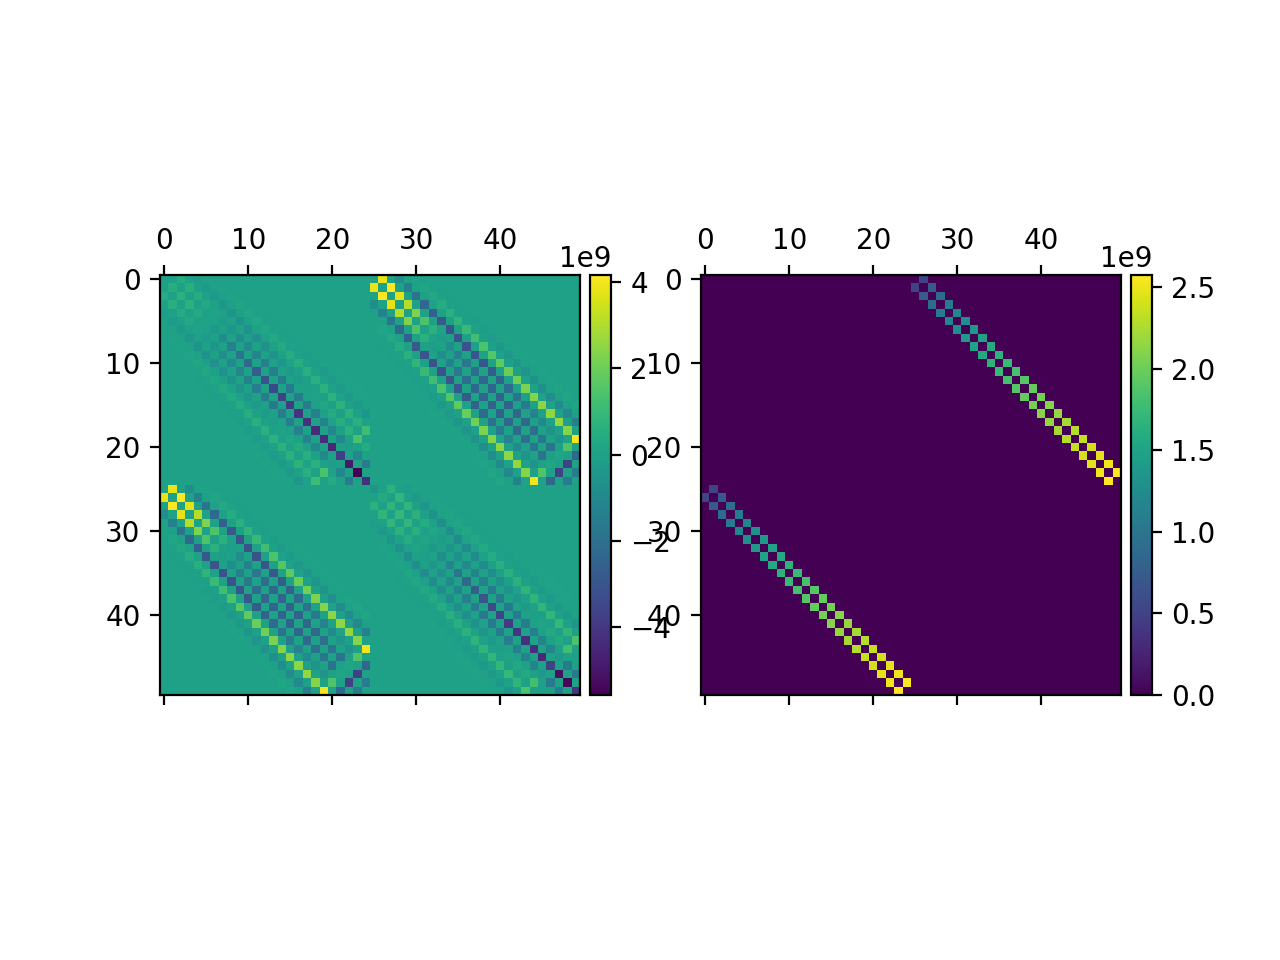

In [138]:
fig, ax = plt.subplots(ncols=2, dpi=200)
c1 = ax[0].matshow(np.real(ΦfΦr_circuit[:50,:50]))
c2 = ax[1].matshow(np.real(ΦfΦr_fr[:50,:50]))
figs.colorbar(c1)
figs.colorbar(c2)
fig.show()

In [202]:
l = Lq * (Lq + 4 * Lr) - 4 * Δ ** 2
L_c = l / Δ * 1e-9

H_f = fluxonium.hamiltonian()
H_r = resonator.hamiltonian() 

I_f = qt.identity(H_f.shape[0])
I_r = qt.identity(H_r.shape[0])

Φ_f = fluxonium.flux_op(0)
Φ_r = resonator.flux_op(0)
Φ_fΦ_r = qt.tensor(Φ_r, Φ_f) / L_c


In [205]:
H_f.__array__().max() / Φ_fΦ_r.__array__().max()

(75.30212334720795+0j)

# Spectrum

## Spectrum vs $φ_\text{ext}$ for different $Δ$

In [143]:
φ_ext_values = np.linspace(0,1,100)
Δ_values_plot = [1e-10, 1e-2, 1e-1, 1]
n_eig = 6
Δ_indices_plot = []

E_qubit_vs_Δ_φext     = np.zeros([len(Δ_values_plot), len(φ_ext_values), n_eig])
E_fluxonium_vs_Δ_φext = np.zeros([len(Δ_values_plot), len(φ_ext_values), n_eig//2])
E_resonator_vs_Δ_φext = np.zeros([len(Δ_values_plot), len(φ_ext_values), n_eig//2])

for i, Δ_value in enumerate(Δ_values_plot):
    Δ_index = (np.abs(Δ_values - Δ_value)).argmin()
    Δ_indices_plot.append(Δ_index)
    qubit_Δ     = qubit_vs_Δ[Δ_index]
    fluxonium_Δ = fluxonium_vs_Δ[Δ_index]
    resonator_Δ = resonator_vs_Δ[Δ_index]

    for j, φ_ext in enumerate(φ_ext_values):
        qubit_Δ    .loops[0].set_flux(φ_ext)
        fluxonium_Δ.loops[0].set_flux(φ_ext)

        E_qubit_vs_Δ_φext    [i, j , :] = qubit_Δ.diag(n_eig)[0]
        E_fluxonium_vs_Δ_φext[i, j , :] = fluxonium_Δ.diag(n_eig//2)[0]
        E_resonator_vs_Δ_φext[i, j , :] = resonator_Δ.diag(n_eig//2)[0]

KeyboardInterrupt: 

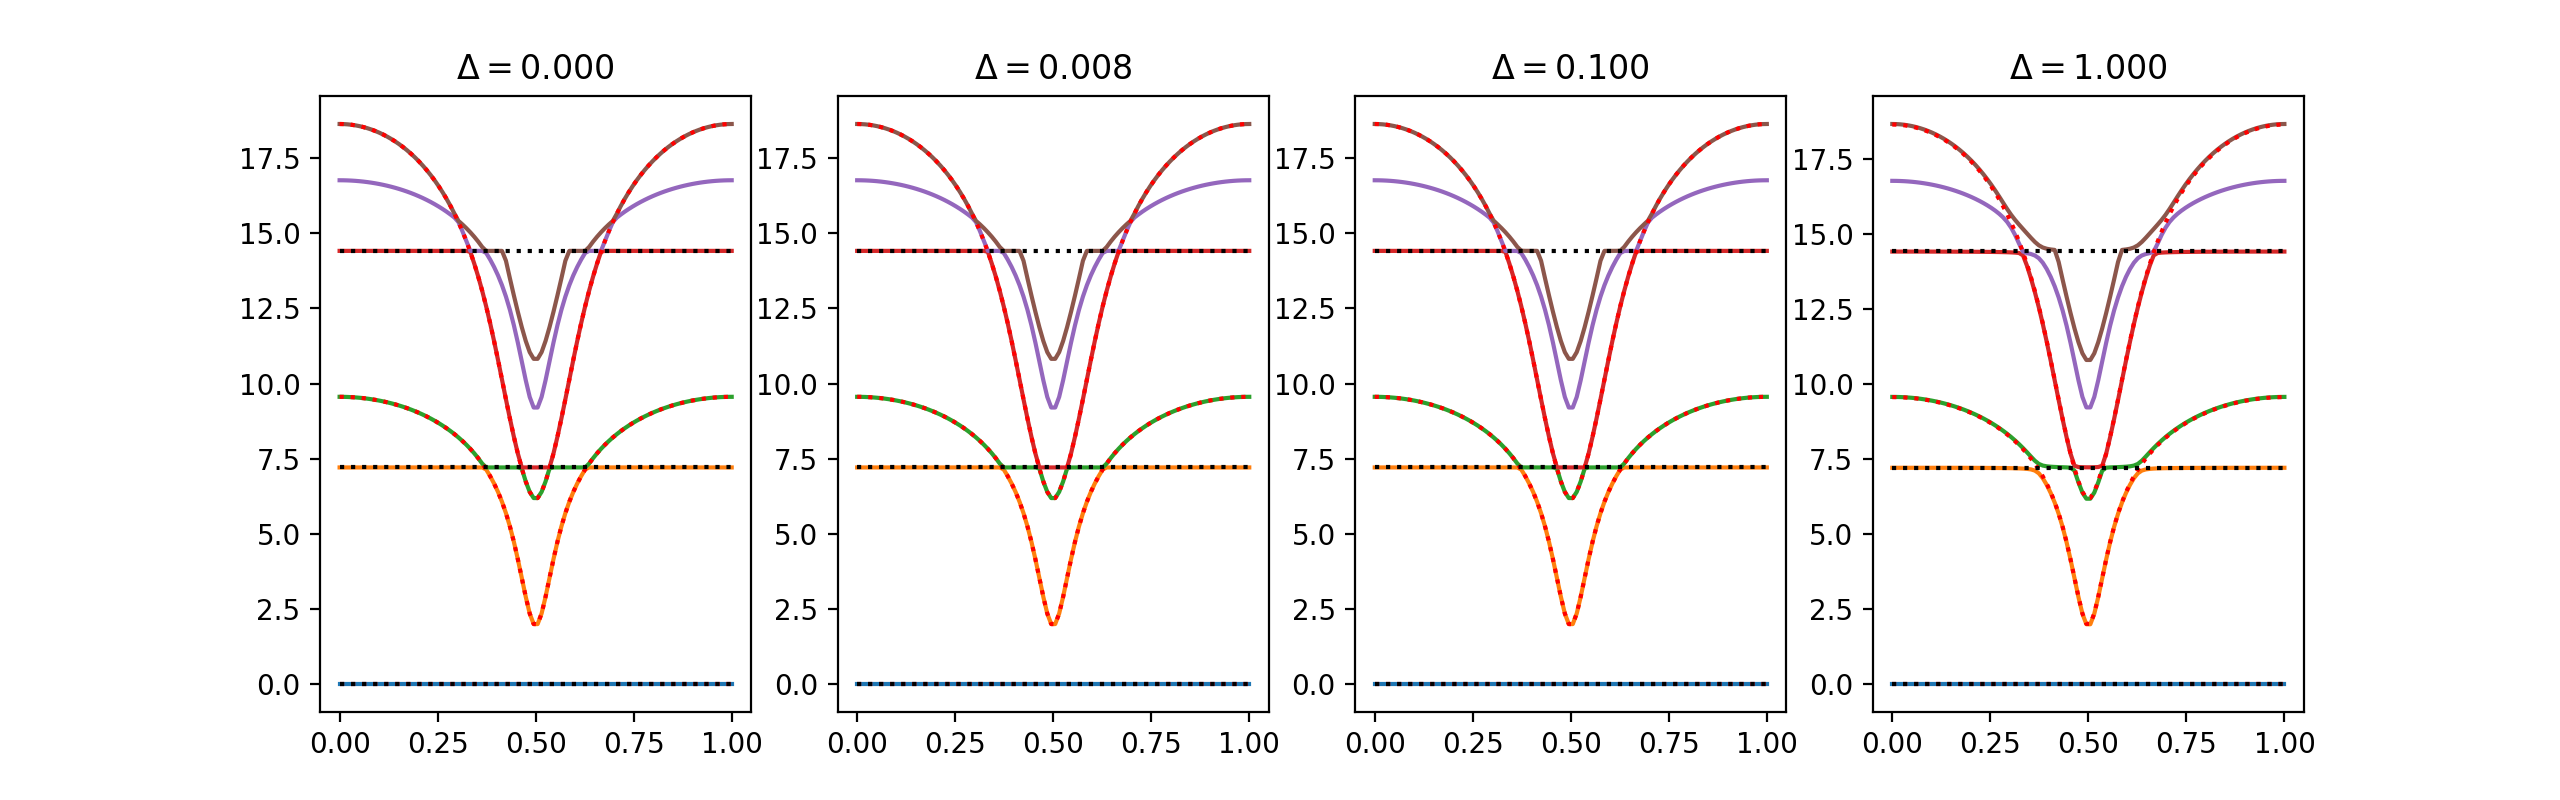

In [146]:
fig, axs = plt.subplots(dpi=200, ncols=len(Δ_values_plot), figsize = [8/2.5*len(Δ_values_plot), 4])

for i in range(len(Δ_values_plot)):
    axs[i].plot(φ_ext_values, E_qubit_vs_Δ_φext[i,:,:]- E_qubit_vs_Δ_φext[i,:,0].reshape(-1,1))
    axs[i].plot(φ_ext_values, E_fluxonium_vs_Δ_φext[i,:,:]- E_fluxonium_vs_Δ_φext[i,:,0].reshape(-1,1), color='r', linestyle = ':')
    axs[i].plot(φ_ext_values, E_resonator_vs_Δ_φext[i,:,:]- E_resonator_vs_Δ_φext[i,:,0].reshape(-1,1), color='k', linestyle = ':')

    axs[i].set_title(r'$\Delta=$' + f'{Δ_values[Δ_indices_plot[i]]:.3f}' )

fig.show()

## Spectrum vs Δ

In [147]:
circuit = qubit
n_eig = 8
circuit.set_trunc_nums([1, 5, 10])
phi = np.linspace(0,0.5,100)

E_circuit = np.zeros((n_eig, len(phi)))

for i in range(len(phi)):
    circuit.loops[0].set_flux(phi[i])
    E_circuit[:, i] = circuit.diag(n_eig)[0]

In [148]:
φext_values = [0, φ_ext_avoided_crossing_1q_1r, 0.5]

E_vs_Δ_φext = np.zeros([len(φext_values), len(Δ_values),  n_eig])

for i, φext in enumerate(φext_values):
    for j, qubit_Δ in enumerate(qubit_vs_Δ):
        qubit_Δ.loops[0].set_flux(φext)
        E_vs_Δ_φext[i, j , :] = qubit_Δ.diag(n_eig)[0]


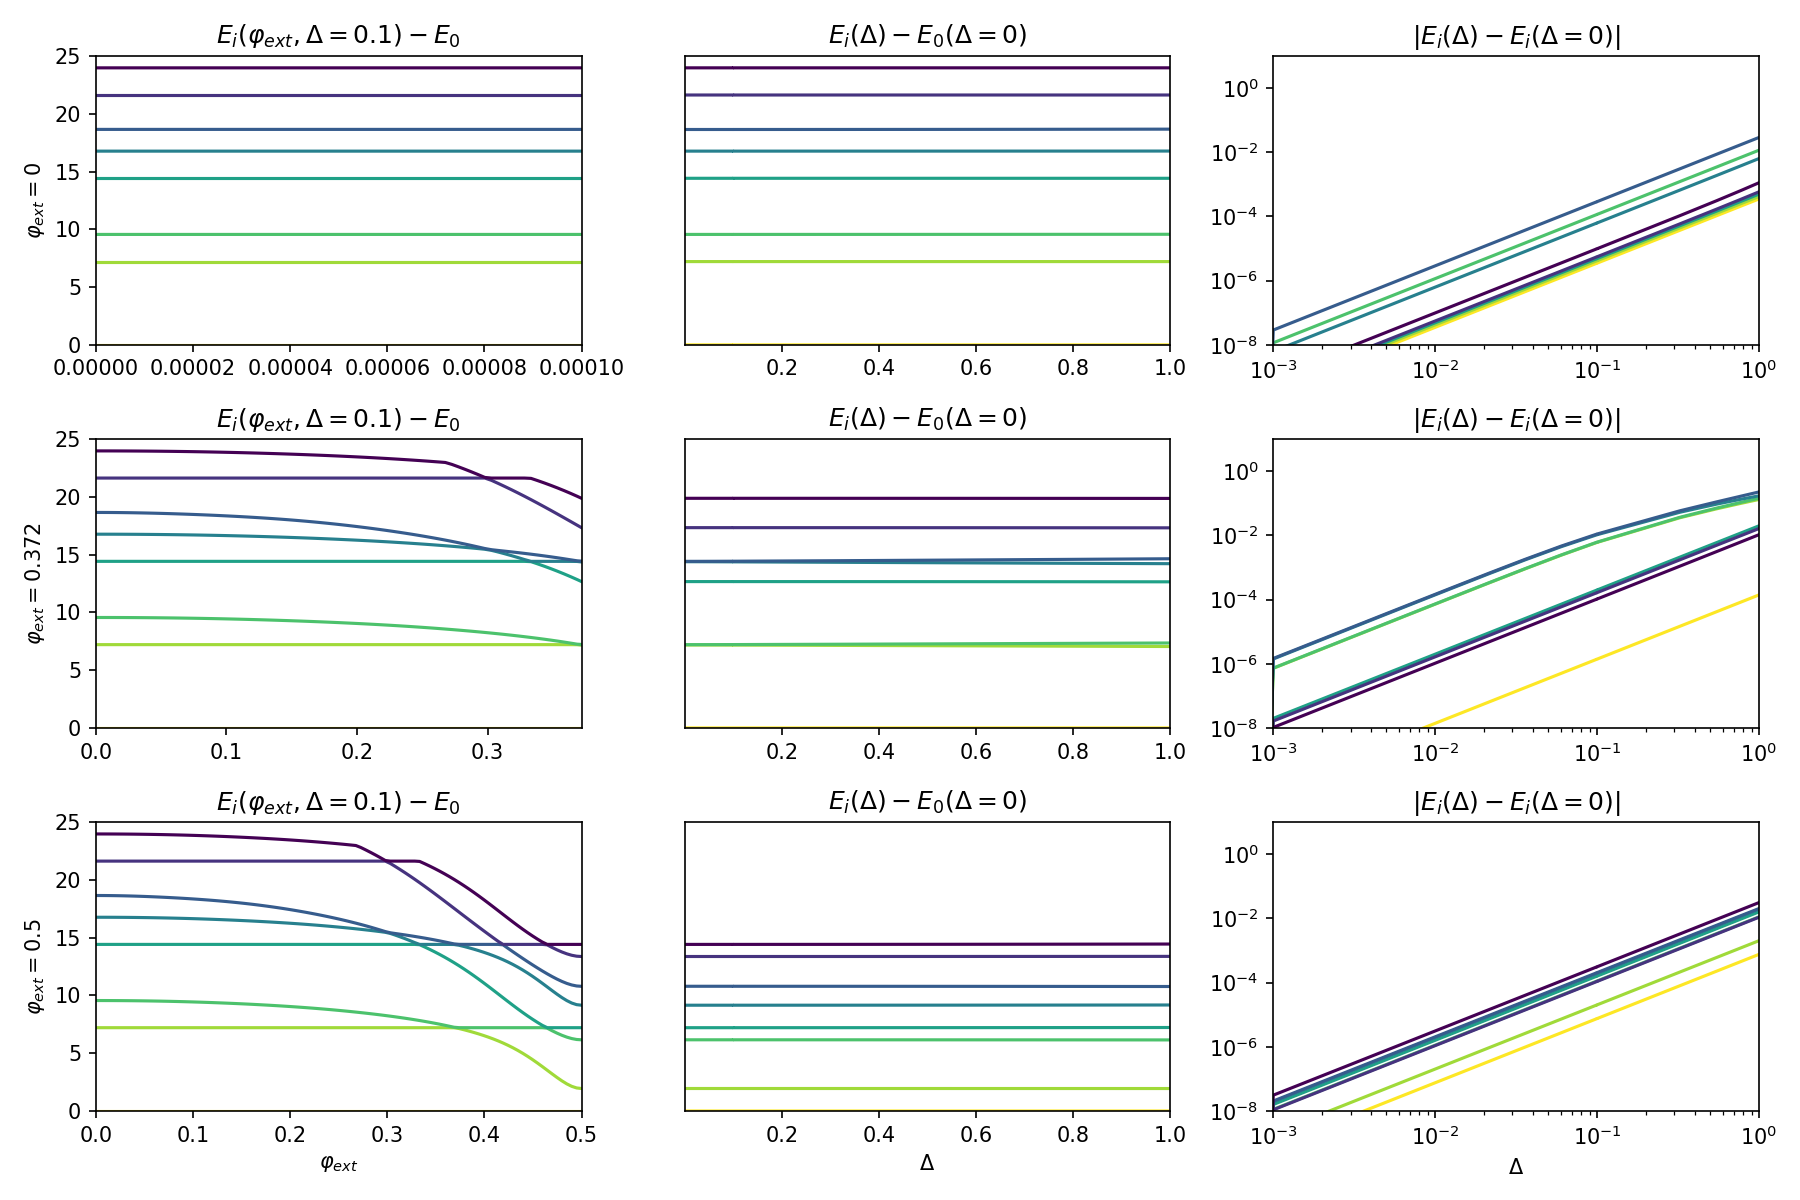

In [149]:
fig, axs = plt.subplots(nrows= 3, ncols = 3, figsize=[12,8], dpi=150)
eig_colors = plt.get_cmap('viridis_r')(np.linspace(0, 255, n_eig).astype('int'))

for i in range(n_eig):
    [axs[j,0].plot(phi, E_circuit[i,:]- E_circuit[0,:], color=eig_colors[i]) for j in range(len(φext_values)) ]

[axs[i,0].set_ylim([0,25]) for i in range(len(φext_values))]
[axs[i,0].set_title(r"$E_i(\varphi_{ext}, \Delta=0.1)-E_0$") for i in range(len(φext_values))]
[axs[i,0].set_ylabel(r'$ \varphi_{ext}=$' + f'{φext_values[i]}' ) for i in range(len(φext_values))]
axs[2,0].set_xlabel(r'$\varphi_{ext}$')

for i, φext in enumerate(φext_values):
    axs[i,0].set_xlim([0, φext+0.0001])
    for j in range(n_eig):
        axs[i,1].plot(Δ_values, E_vs_Δ_φext[i, :, j]- E_vs_Δ_φext[i, 0, 0], color=eig_colors[j])
        axs[i,2].plot(Δ_values, np.abs(E_vs_Δ_φext[i, :, j]- E_vs_Δ_φext[i, 0, j]), color=eig_colors[j])

    axs[i,1].margins(0)
    axs[i,1].set_ylim([0,25])
    axs[i,1].set_yticks([])
    axs[i,1].set_title(r'$E_i(\Delta)-E_0(\Delta=0)$')
    # axs[i,1].set_xscale('log')
    axs[i,2].set_title(r'$|E_i(\Delta)-E_i(\Delta=0)|$')
    axs[i,2].set_xscale('log')
    axs[i,2].set_yscale('log')
    axs[i,2].margins(0)
    axs[i,2].set_ylim([1e-8, 1e1])
    axs[i,2].set_xlim([Δ_values[1], Δ_values[-1]])

axs[2,1].set_xlabel(r'$\Delta$')
axs[2,2].set_xlabel(r'$\Delta$')

fig.tight_layout()
fig.show()

## Wavefunctions

In [74]:
# φ_ext = 0
# φ_ext = φ_ext_avoided_crossing
φ_ext = 0.5

φ_r = np.linspace(-3,3,200)
φ_f = np.linspace(-3, 3, 200)

φ_2 = np.linspace(-.03, .03, 100)/2/np.pi
φ_3 = np.linspace(-3, 3 , 100)/2/np.pi
grid_q = [0, φ_2, φ_3]

Ψ_r_0_vs_Δ = []
Ψ_r_1_vs_Δ = []
Ψ_f_0_vs_Δ = []
Ψ_f_1_vs_Δ = []
V_f_vs_Δ = []
Ψ_q_0_vs_Δ = []
Ψ_q_1_vs_Δ = []

n_eig = 4

for resonator_Δ, fluxonium_Δ, qubit_Δ, Δ in zip(resonator_vs_Δ, fluxonium_vs_Δ, qubit_vs_Δ, Δ_values):
    fluxonium_Δ.loops[0].set_flux(φ_ext)
    qubit_Δ.loops[0].set_flux(φ_ext)

    _, _ = resonator_Δ.diag(n_eig)
    # Ψ_r_0_vs_Δ.append( np.abs(resonator_Δ.eig_phase_coord(k=0, grid=[φ_r/2/np.pi]))**2 )
    # Ψ_r_1_vs_Δ.append( np.abs(resonator_Δ.eig_phase_coord(k=1, grid=[φ_r/2/np.pi]))**2 )

    V_r = 0.5 * E_L_r * φ_r **2

    _, _ = fluxonium_Δ.diag(n_eig)
    # Ψ_f_0_vs_Δ.append( np.abs(fluxonium_Δ.eig_phase_coord(k=0, grid=[φ_f/2/np.pi]))**2 )
    # Ψ_f_1_vs_Δ.append( np.abs(fluxonium_Δ.eig_phase_coord(k=1, grid=[φ_f/2/np.pi]))**2 )

    l_Δ = Lq*(Lq+4*Lr) - 4*Δ**2
    L_q = l_Δ / (Lq + 4 * Lr) * 1e-9
    E_L_f = (Φ_0 / (2 * np.pi)) ** 2 / L_q / h
    V_f_Δ = 0.5 * E_L_f * (φ_f) ** 2 - E_J * np.cos(φ_f - φ_ext * 2 * np.pi)
    V_f_vs_Δ.append( (V_f_Δ-V_f_Δ.min())/1e9 )

    _, _ = qubit_Δ.diag(n_eig)
    # Ψ_q_0_vs_Δ.append( np.abs(qubit_Δ.eig_phase_coord(k=0, grid=grid_q).T)**2 )
    # Ψ_q_1_vs_Δ.append( np.abs(qubit_Δ.eig_phase_coord(k=1, grid=grid_q).T)**2 )

In [81]:
fig, axs = plt.subplots(ncols=2)
                       
axs[0].plot(φ_r, (V_r-V_r.min())/1e9, 'k:')
Ψ_r_0_plot, = axs[0].plot(φ_r, Ψ_r_0_vs_Δ[0], label=r'$\psi_R^0$')
Ψ_r_1_plot, = axs[0].plot(φ_r, Ψ_r_1_vs_Δ[0], label=r'$\psi_R^1$')
axs[0].set_xlabel(r'$\varphi_R$')
axs[0].set_ylim([-.1,3])

V_f_plot, =   axs[1].plot(φ_f, V_f_vs_Δ[0] , 'k:')
Ψ_f_0_plot, = axs[1].plot(φ_f, Ψ_f_0_vs_Δ[0], label=r'$\psi_F^0$')
Ψ_f_1_plot, = axs[1].plot(φ_f, Ψ_f_1_vs_Δ[0], label=r'$\psi_F^1$')
axs[1].set_xlabel(r'$\varphi_F$')
axs[1].set_ylim([-.1,4])

ani = figs.animation(fig, [Ψ_r_0_plot, Ψ_r_1_plot, Ψ_f_0_plot, Ψ_f_1_plot, V_f_plot], 
                          [Ψ_r_0_vs_Δ, Ψ_r_1_vs_Δ, Ψ_f_0_vs_Δ, Ψ_f_1_vs_Δ, V_f_vs_Δ],
                           r'$\Delta=$', Δ_values)
 
HTML(ani.to_jshtml())

NameError: name 'φ_r' is not defined

In [152]:
fig, axs = plt.subplots(ncols=2)
                       
Ψ_q_0_plot = axs[0].contourf(φ_3, φ_2, Ψ_q_0_vs_Δ[0], cmap="Blues")
axs[0]. set_ylabel(r'$\tilde{\varphi}_R$')
axs[0]. set_xlabel(r'$\tilde{\varphi}_F$')
axs[0].text(.9,.9, r'$\psi^0$', transform=axs[0].transAxes, ha="center", va="center")

Ψ_q_1_plot = axs[1].contourf(φ_3, φ_2, Ψ_q_1_vs_Δ[1], cmap="Oranges")
axs[1]. set_ylabel(r'$\tilde{\varphi}_R$')
axs[1]. set_xlabel(r'$\tilde{\varphi}_F$')
axs[1].text(.9,.9, r'$\psi^1$', transform=axs[1].transAxes, ha="center", va="center")

ani = figs.animation_contour(fig, [Ψ_q_0_plot, Ψ_q_1_plot ],
                                   φ_3, φ_2, 
                                  [Ψ_q_0_vs_Δ, Ψ_q_1_vs_Δ],
                                   r'$\Delta=$', Δ_values)
 
HTML(ani.to_jshtml())

# Fluxonium-Resonator internal coupling

In [153]:
# φ_ext_values = np.concatenate((np.linspace(0, 0.3, 20), np.linspace(0.3, 0.5, 80) ))
# φ_ext_values = np.linspace(0,0.5,50)
φ_ext_values = np.array([0.5, 0.49, 0.1, 0])
φ_ext_values = np.array([0.5, 0])
n_eig = 8

I = np.eye(n_eig)
H_eff_vs_Δ_φ_ext = np.zeros([len(φ_ext_values), len(Δ_values), n_eig, n_eig], dtype='complex')
H_eff_p1_vs_Δ_φ_ext = np.zeros([len(φ_ext_values), len(Δ_values), n_eig, n_eig], dtype='complex')
H_eff_p1_f_r_vs_Δ_φ_ext = np.zeros([len(φ_ext_values), len(Δ_values), n_eig, n_eig], dtype='complex')
H_eff_p2_f_r_vs_Δ_φ_ext = np.zeros([len(φ_ext_values), len(Δ_values), n_eig, n_eig], dtype='complex')
H_eff_p2_vs_Δ_φ_ext = np.zeros([len(φ_ext_values), len(Δ_values), n_eig, n_eig], dtype='complex')
U_vs_Δ_φ_ext = np.zeros([len(φ_ext_values), len(Δ_values), n_eig, n_eig])
N_f_vs_Δ_φ_ext = np.zeros([len(φ_ext_values), len(Δ_values), n_eig], dtype='int')
N_r_vs_Δ_φ_ext = np.zeros([len(φ_ext_values), len(Δ_values), n_eig], dtype='int')

for i, φ_ext in enumerate(φ_ext_values):
    qubit_nonint = qubit_vs_Δ[0]
    qubit_nonint.loops[0].set_flux(φ_ext)
    _ = qubit_nonint.diag(n_eig)

    fluxonium_nonint = fluxonium_vs_Δ[0]
    fluxonium_nonint.loops[0].set_flux(φ_ext)
    _ = fluxonium_nonint.diag(n_eig)

    resonator_nonint = resonator_vs_Δ[0]
    _ = resonator_nonint.diag(n_eig)

    for j, (qubit_Δ, fluxonium_Δ, resonator_Δ ) in enumerate( zip(qubit_vs_Δ, fluxonium_vs_Δ, resonator_vs_Δ )):
        qubit_Δ    .loops[0].set_flux(φ_ext)
        fluxonium_Δ.loops[0].set_flux(φ_ext)

        _ = qubit_Δ    .diag(n_eig)
        _ = fluxonium_Δ.diag(n_eig)
        _ = resonator_Δ.diag(n_eig)

        H_eff_vs_Δ_φ_ext[i, j, :], U_vs_Δ_φ_ext[i, j, :] = sq_ext.H_eff_SWT_circuit(qubit_nonint, qubit_Δ, return_transformation=True)
        H_eff_p1_vs_Δ_φ_ext[i, j, :] = sq_ext.H_eff_p1(qubit_nonint, qubit_Δ)
        H_eff_p2_vs_Δ_φ_ext[i, j, :] = sq_ext.H_eff_p2(qubit_nonint, qubit_Δ)

        N_f, N_r = sq_ext.get_energy_indices(qubit_Δ, fluxonium_Δ, resonator_Δ)
        N_f_vs_Δ_φ_ext[i, j, :] = N_f
        N_r_vs_Δ_φ_ext[i, j, :] = N_r
        if j == 0:
            continue
        try:
            H_eff_p1_f_r_vs_Δ_φ_ext[i, j, :] = sq_ext.H_eff_p1_fluxonium_resonator(fluxonium_nonint, fluxonium_Δ, resonator_nonint, resonator_Δ, N_f, N_r, Δ_values[j])
            H_eff_p2_f_r_vs_Δ_φ_ext[i, j, :] = sq_ext.H_eff_p2_fluxonium_resonator(fluxonium_nonint, fluxonium_Δ, resonator_nonint, resonator_Δ, N_f, N_r, Δ_values[j])
        except:
            pass

C:\Users\gabri\AppData\Local\Temp\ipykernel_10136\185946019.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  H_eff_vs_Δ_φ_ext[i, j, :], U_vs_Δ_φ_ext[i, j, :] = sq_ext.H_eff_SWT_circuit(qubit_nonint, qubit_Δ, return_transformation=True)
C:\Users\gabri\PycharmProjects\tunable-capacitive-coupling-flux-qubits\Modules\SQcircuit_extensions.py:260: RuntimeWarning: divide by zero encountered in scalar divide
  (1 / (E_0[i] - E[k]) + 1 / (E_0[j] - E[k])) *
C:\Users\gabri\PycharmProjects\tunable-capacitive-coupling-flux-qubits\Modules\SQcircuit_extensions.py:260: RuntimeWarning: invalid value encountered in scalar multiply
  (1 / (E_0[i] - E[k]) + 1 / (E_0[j] - E[k])) *
C:\Users\gabri\PycharmProjects\tunable-capacitive-coupling-flux-qubits\Modules\SQcircuit_extensions.py:172: RuntimeWarning: divide by zero encountered in scalar divide
  coef = 1 / (E_0_i-E_k) + 1 / (E_0_j-E_k)
C:\Users\gabri\PycharmProjects\tunable-capacitive-coupling-flux-qubits\Modules\SQcirc

In [16]:
H_eff_p2_f_r_vs_Δ_φ_ext *= 2e6

In [155]:
φ_ext = φ_ext_avoided_crossing_1q_1r
φ_ext = 0
φ_ext = 0.5
n_eig_plot = 6
colors = figs.generate_colors_from_colormap(20, 'tab20')
label_color_dict ={}

# φ_ext_values_plot = [0.5, φ_ext_avoided_crossing_2q_1r, φ_ext_avoided_crossing_1q_1r, 0]
φ_ext_values_plot = np.array(φ_ext_values)
φ_ext_values_plot = np.array([0, 0.5])

fig, axs = plt.subplots(ncols = 3, nrows=len(φ_ext_values_plot), dpi=200, figsize = [12,12])

for l, H_eff in enumerate([H_eff_vs_Δ_φ_ext, H_eff_p1_vs_Δ_φ_ext, H_eff_p2_vs_Δ_φ_ext]):
    ax = axs[:,l]
    for k, φ_ext in enumerate(φ_ext_values_plot):
        φ_ext_index = (np.abs(φ_ext_values - φ_ext)).argmin()

        for i in range(n_eig_plot):
            for j in range(i, n_eig_plot):
                # label, i_f, j_f, i_r, j_r = \
                #     sq_ext.get_state_label(N_f_vs_Δ_φ_ext[φ_ext_index,1,:], N_r_vs_Δ_φ_ext[φ_ext_index,1,:], i, j, return_numeric_indices=True)
                # color, label_color_dict, _ = sq_ext.get_or_assign_color(label, colors, label_color_dict)

                # Effective hamiltonians using the full circuit
                if np.any(np.abs(H_eff[φ_ext_index, 1:, i, j])>1e-3) or \
                   np.any(np.abs(H_eff[φ_ext_index, 1:, i, j]-H_eff[φ_ext_index, 0, i, j])>1e-3):
                    if i != j:
                        label, i_f, j_f, i_r, j_r = \
                        sq_ext.get_state_label(N_f_vs_Δ_φ_ext[φ_ext_index,1,:], N_r_vs_Δ_φ_ext[φ_ext_index,1,:], i, j, return_numeric_indices=True)
                        color, label_color_dict, _ = sq_ext.get_or_assign_color(label, colors, label_color_dict)
                        ax[k].plot(Δ_values[1:], np.abs(H_eff[φ_ext_index, 1:, i, j]), '-.', label=label, color=color)
                    else:
                        # label, i_f, j_f, i_r, j_r = \
                        # sq_ext.get_state_label(N_f_vs_Δ_φ_ext[φ_ext_index,1,:], N_r_vs_Δ_φ_ext[φ_ext_index,1,:], i, j, return_numeric_indices=True)
                        # color, label_color_dict, _ = sq_ext.get_or_assign_color(label, colors, label_color_dict)
                        # ax[k].plot(Δ_values[1:], np.abs(H_eff[φ_ext_index, 1:, i, j]-H_eff[φ_ext_index, 0, i, j]), label=label, color=color, alpha=0.5)

                # First order effective hamiltonian using fluxonium + resonator model
                if np.any(np.abs(H_eff_p1_f_r_vs_Δ_φ_ext[φ_ext_index, 1:, i, j])>1e-3) or \
                   np.any(np.abs(H_eff_p1_f_r_vs_Δ_φ_ext[φ_ext_index, 1:, i, j]-H_eff_p1_f_r_vs_Δ_φ_ext[φ_ext_index, 0, i, j])>1e-3):
                    if i != j: 
                        ax[k].plot(Δ_values[1:], np.abs(H_eff_p1_f_r_vs_Δ_φ_ext[φ_ext_index, 1:, i, j]), '*', label=label+' P_1', color=color, alpha=0.5)
                    # else:
                    #     ax[k].plot(Δ_values[1:], np.abs(H_eff_p1_f_r_vs_Δ_φ_ext[φ_ext_index, 1:, i, j]-H_eff_p1_f_r_vs_Δ_φ_ext[φ_ext_index, 0, i, j]),'*', label=label, color=color, alpha=0.5)

                # Second order effective hamiltonian using fluxonium + resonator model
                if np.any(np.abs(H_eff_p2_f_r_vs_Δ_φ_ext[φ_ext_index, 1:, i, j])>1e-3) or \
                   np.any(np.abs(H_eff_p2_f_r_vs_Δ_φ_ext[φ_ext_index, 1:, i, j]-H_eff_p2_f_r_vs_Δ_φ_ext[φ_ext_index, 0, i, j])>1e-3):
                    if i != j:
                        ax[k].plot(Δ_values[1:], np.abs(H_eff_p2_f_r_vs_Δ_φ_ext[φ_ext_index, 1:, i, j]), 's', markersize=3, label=label+' P_2', color=color)
                    # else:
                    #     ax[k].plot(Δ_values[1:], np.abs(H_eff_p2_f_r_vs_Δ_φ_ext[φ_ext_index, 1:, i, j]-H_eff_p2_f_r_vs_Δ_φ_ext[φ_ext_index, 0, i, j]),'s', markersize=3, label=label, color=color)

        ax[k].set_xlabel('$\Delta$')
        ax[k].set_xscale('log')
        ax[k].set_yscale('log')
        # ax[k].set_ylim([1e-7,1e0])
        if l == 0:
            ax[k].set_title((r'$H_{eff}^{SWT_{exact}}(\Delta, \varphi_{ext}=$' + f'{φ_ext_values[φ_ext_index]:.3f})'))

        elif l == 1:
            ax[k].set_title((r'$H_{eff}^{SWT_{p1}}(\Delta, \varphi_{ext}=$' + f'{φ_ext_values[φ_ext_index]:.3f})'))
            
        else:
            ax[k].set_title((r'$H_{eff}^{SWT_{p2}}(\Delta, \varphi_{ext}=$' + f'{φ_ext_values[φ_ext_index]:.3f})'))
            ax[k].legend(loc='upper left', bbox_to_anchor=(1, 1))

fig.tight_layout()
fig.show()

ValueError: Data has no positive values, and therefore can not be log-scaled.

In [70]:
circ_0 = qubit_vs_Δ[0]
circ = qubit_vs_Δ[-1]
ψ_0 = sq_ext.real_eigenvectors(np.array([ψ_i.__array__()[:, 0] for ψ_i in circ_0._evecs]).T)
ψ   = sq_ext.real_eigenvectors(np.array([ψ_i.__array__()[:, 0] for ψ_i in circ.  _evecs]).T)
E_0 = circ_0.efreqs
E   = circ  .efreqs
H_0 = circ_0.hamiltonian().__array__() / GHz /2 /np.pi
H   = circ  .hamiltonian().__array__() / GHz /2 /np.pi
V   = (H-H_0)

In [31]:
H_eff_1 = ψ_0.conj().T @ H @ ψ_0
n_eig = ψ_0.shape[1]
H_eff_2 = np.zeros((n_eig, n_eig), dtype=complex)  # matrix to store our results.

for i in range(n_eig):
    for j in range(n_eig):
        H_eff_2[i, j] = 1 / 2 * sum(
                      (1 / (E_0[i] - E[k]) + 1 / (E_0[j] - E[k])) *
                       (ψ_0[:, i].T.conj() @ V @ ψ[:, k]) * \
                       (ψ[:, k].T.conj() @ V @ ψ_0[:, j])
                       for k in range(n_eig))

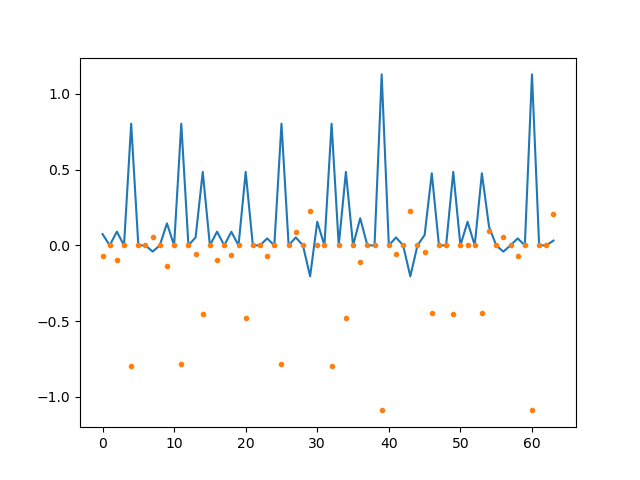

In [110]:
fig, ax = plt.subplots()
ax.plot(H_eff_1.ravel())
ax.plot(H_eff_2.ravel(), '.')
fig.show()

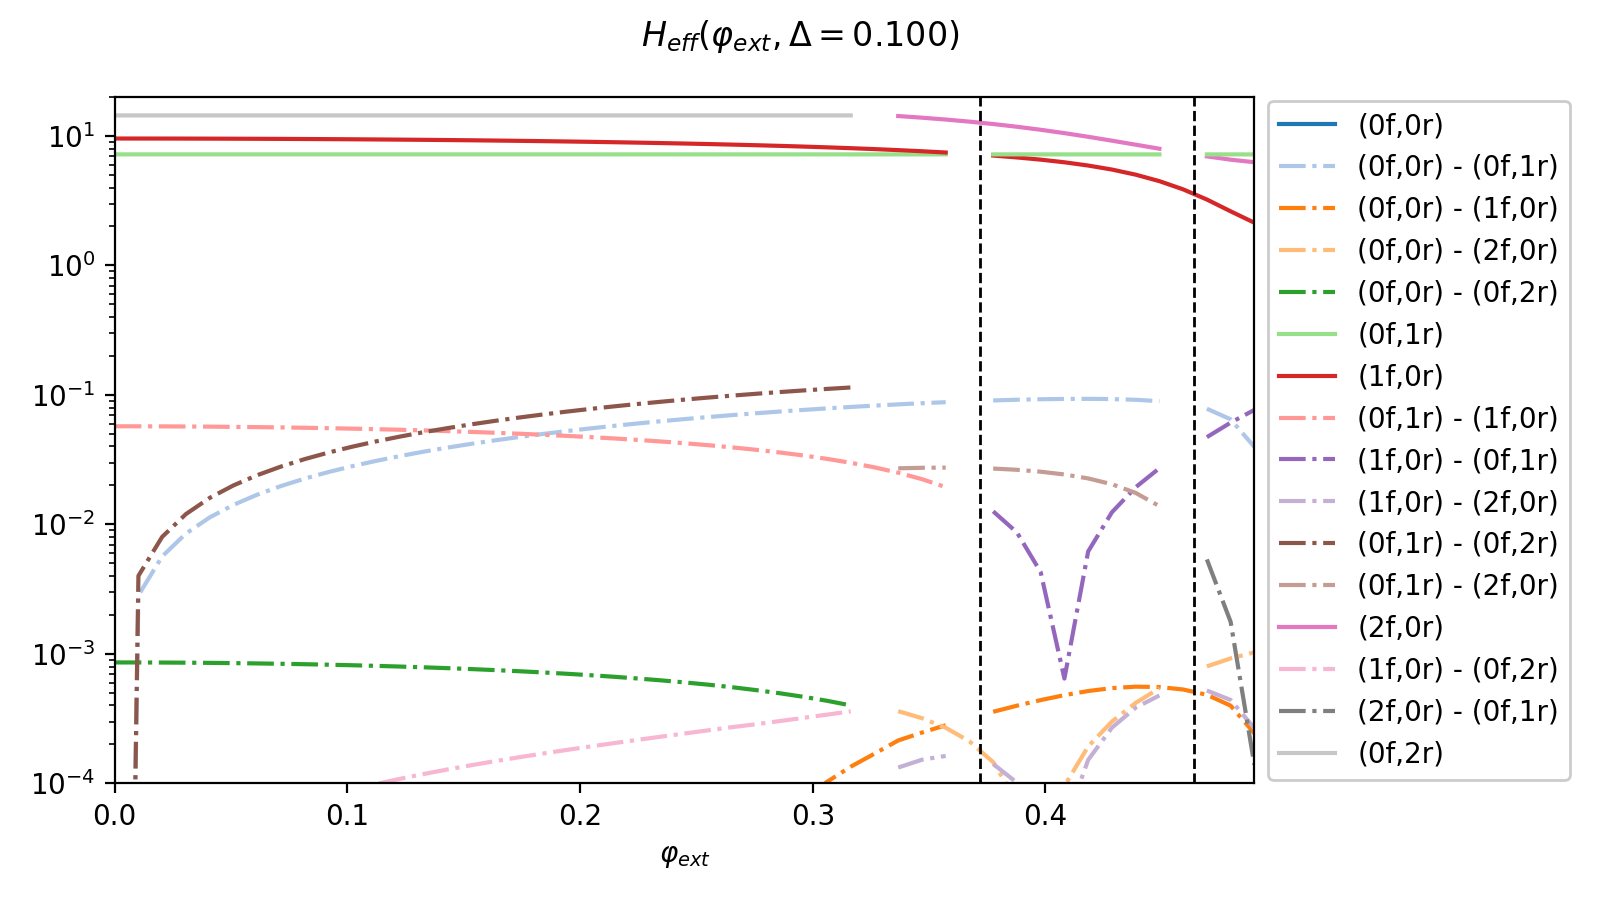

In [167]:
Δ_value = 0.1

fig, ax = plt.subplots(dpi=200, figsize = [8,4.5])
Δ_index = (np.abs(Δ_values - Δ_value)).argmin()
colors = figs.generate_colors_from_colormap(20, 'tab20')
# colors = figs.generate_colors_from_colormap(30, 'viridis')
label_color_dict ={}
n_eig_plot=4

for i in range(n_eig_plot):
    for j in range(i, n_eig_plot):
        if np.any(np.abs(H_eff_vs_Δ_φ_ext[:, Δ_index, i, j])>1e-2) or \
                np.any(H_eff_vs_Δ_φ_ext[:, Δ_index, i, j]-H_eff_vs_Δ_φ_ext[:, Δ_index, 0, 0]>1e-2):
            labels = [sq_ext.get_state_label(N_f, N_r, i, j) for N_f, N_r in zip(N_f_vs_Δ_φ_ext[:,Δ_index], N_r_vs_Δ_φ_ext[:,Δ_index]) ]
            labels_and_intervals = sq_ext.find_indices(labels)

            for label, interval in labels_and_intervals:
                color, label_color_dict, newly_assigned = sq_ext.get_or_assign_color(label, colors, label_color_dict)
                if not newly_assigned:
                    label=None
                if i==j:
                    ax.plot(φ_ext_values[interval[0]:interval[-1]],\
                            H_eff_vs_Δ_φ_ext[interval[0]:interval[-1], Δ_index, i, j]- H_eff_vs_Δ_φ_ext[interval[0]:interval[-1], Δ_index, 0, 0], \
                            label=label, color=color)
                else:
                    ax.plot(φ_ext_values[interval[0]:interval[-1]], \
                            np.abs(H_eff_vs_Δ_φ_ext[interval[0]:interval[-1], Δ_index, i, j]), \
                            '-.',label=label, color=color)

ax.legend(framealpha=1, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel(r'$\varphi_{ext}$')
ax.set_yscale('log')
fig.suptitle((r'$H_{eff}(\varphi_{ext}, \Delta=$' + f'{Δ_values[Δ_index]:.3f})'))
ax.set_ylim([1e-4,2e1])
ax.margins(0)
ax.vlines([φ_ext_avoided_crossing_1q_1r, φ_ext_avoided_crossing_2q_1r], 1e-5, 2e1, 'k', '--', linewidth=1)
fig.tight_layout()
fig.show()

In [ ]:
U_to_I_vs_Δ_φ_ext = np.zeros([len(φ_ext_values), len(qubit_vs_Δ)])
p1_to_SWT_vs_Δ_φ_ext = np.zeros([len(φ_ext_values), len(qubit_vs_Δ)])
g_vs_Δ_φ_ext = np.zeros([len(φ_ext_values), len(qubit_vs_Δ)])
for i in range(len(φ_ext_values)):
    for j in range(len(qubit_vs_Δ)):
        g = []
        for k in range(4):
            for l in range(k+1, 4):
                g.append(H_eff_vs_Δ_φ_ext[i, j, k, l ])
        g_vs_Δ_φ_ext[i,j] = max(g)
        U_to_I_vs_Δ_φ_ext[i,j] = np.sum((U_vs_Δ_φ_ext[i, j] - I)**2)
        p1_to_SWT_vs_Δ_φ_ext[i,j] = np.sum((H_eff_vs_Δ_φ_ext[i, j,:4,:4] - H_eff_p1_vs_Δ_φ_ext[i, j,:4,:4])**2)

In [ ]:
fig, ax = plt.subplots(dpi=200, figsize = [8,5])

cont = ax.contourf(φ_ext_values, Δ_values[1:], np.log(g_vs_Δ_φ_ext[:,1:].T), vmin=-6, levels=np.linspace(-6,2,9))
ax.vlines([φ_ext_avoided_crossing_1q_1r, φ_ext_avoided_crossing_2q_1r], 1e-3, 1e1, 'k', '--', linewidth=1)
ax.set_yscale('log')
fig.colorbar(cont, ticks=np.arange(-6,3))
fig.suptitle('$log(g)$')
ax.set_ylabel(r'$\Delta$')
ax.set_xlabel(r'$\varphi_{ext}$')
fig.show()

In [ ]:
fig, ax = plt.subplots(dpi=200, figsize = [8,5])
cont = ax.contourf(φ_ext_values, Δ_values[1:], np.log(U_to_I_vs_Δ_φ_ext[:,1:].T))#, vmin=-6, levels=np.linspace(-6,2,9))
ax.vlines([φ_ext_avoided_crossing_1q_1r, φ_ext_avoided_crossing_2q_1r], 1e-3, 1e1, 'k', '--', linewidth=1)
ax.set_yscale('log')
fig.suptitle(r'$log||U-I||$')
fig.colorbar(cont)
ax.set_ylabel(r'$\Delta$')
ax.set_xlabel(r'$\varphi_{ext}$')
fig.show()

In [ ]:
fig, ax = plt.subplots(dpi=200, figsize = [8,5])
cont = ax.contourf(φ_ext_values, Δ_values[1:], np.log(p1_to_SWT_vs_Δ_φ_ext[:,1:].T))#, vmin=-6, levels=np.linspace(-6,2,9))
ax.vlines([φ_ext_avoided_crossing_1q_1r, φ_ext_avoided_crossing_2q_1r], 1e-3, 1e1, 'k', '--', linewidth=1)
ax.set_yscale('log')
fig.suptitle(r'$log||H_{eff}^{SWT}-H_{eff}^{p1}||$')
fig.colorbar(cont)
ax.set_ylabel(r'$\Delta$')
ax.set_xlabel(r'$\varphi_{ext}$')
fig.show()

In [39]:
N_r_vs_Δ_φ_ext

array([[[0.0e+00, 2.0e+00, 1.0e+00, 3.0e+00],
        [0.0e+00, 1.0e+00, 0.0e+00, 2.0e+00],
        [0.0e+00, 1.0e+00, 0.0e+00, 2.0e+00],
        ...,
        [0.0e+00, 1.0e+00, 0.0e+00, 2.0e+00],
        [0.0e+00, 1.0e+00, 0.0e+00, 2.0e+00],
        [0.0e+00, 1.0e+00, 0.0e+00, 2.0e+00]],

       [[0.0e+00, 2.0e+00, 1.0e+00, 3.0e+00],
        [0.0e+00, 1.0e+00, 0.0e+00, 2.0e+00],
        [0.0e+00, 1.0e+00, 0.0e+00, 2.0e+00],
        ...,
        [0.0e+00, 1.0e+00, 0.0e+00, 2.0e+00],
        [0.0e+00, 1.0e+00, 0.0e+00, 2.0e+00],
        [0.0e+00, 1.0e+00, 0.0e+00, 2.0e+00]],

       [[0.0e+00, 2.0e+00, 1.0e+00, 3.0e+00],
        [0.0e+00, 1.0e+00, 0.0e+00, 2.0e+00],
        [0.0e+00, 1.0e+00, 0.0e+00, 2.0e+00],
        ...,
        [0.0e+00, 1.0e+00, 0.0e+00, 2.0e+00],
        [0.0e+00, 1.0e+00, 0.0e+00, 2.0e+00],
        [0.0e+00, 1.0e+00, 0.0e+00, 2.0e+00]],

       ...,

       [[0.0e+00, 1.0e+00, 2.0e+00, 1.0e+00],
        [0.0e+00, 0.0e+00, 0.0e+00, 1.0e+00],
        [0.0e+00, 0.0e

In [60]:
fig, ax = plt.subplots(dpi=200, figsize = [8,5])
cont = ax.contourf(φ_ext_values, Δ_values[1:], N_f_vs_Δ_φ_ext[:,1:,0].T)#, vmin=-6, levels=np.linspace(-6,2,9))
# ax.vlines([φ_ext_avoided_crossing_1q_1r, φ_ext_avoided_crossing_2q_1r], 1e-3, 1e1, 'k', '--', linewidth=1)
ax.set_yscale('log')
# fig.suptitle(r'$log||H_{eff}^{SWT}-H_{eff}^{p1}||$')
fig.colorbar(cont)
ax.set_ylabel(r'$\Delta$')
ax.set_xlabel(r'$\varphi_{ext}$')
fig.show()